# Mount Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Check GPU Resources

In [1]:
!pip freeze > requirements.txt

In [2]:
!nvidia-smi

Thu Dec  7 06:52:48 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0    45W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

#Install AutoTime to Measure the runtime

In [3]:
!pip install ipython-autotime hypopt
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 25.7 MB/s eta 0:00:00
time: 264 µs (started: 2023-12-07 06:52:55 +00:00)


# Import Libraries

In [4]:
import pandas as pd
import nltk
import re
from nltk.corpus import stopwords
nltk.download('stopwords')
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import classification_report,confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, KFold, cross_val_score, RandomizedSearchCV
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import SGDClassifier, LogisticRegression
from joblib import dump, load
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import tree
import numpy as np
import itertools
from hypopt import GridSearch

from time import time

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


time: 1.85 s (started: 2023-12-07 06:52:55 +00:00)


# Common Methods

## Plot The Confusion Matrix

In [5]:
## https://github.com/parthpatwa/covid19-fake-news-detection/blob/main/ml_baseline-test.ipynb
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(5, 4))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    #plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.show()

time: 992 µs (started: 2023-12-07 06:52:57 +00:00)


In [6]:
stops = set(stopwords.words("english"))
def cleantext(string):
    text = string.lower().split()
    text = " ".join(text)
    text = re.sub(r"http(\S)+",' ',text)
    text = re.sub(r"www(\S)+",' ',text)
    text = re.sub(r"&",' and ',text)
    tx = text.replace('&amp',' ')
    text = re.sub(r"[^0-9a-zA-Z]+",' ',text)
    text = text.split()
    text = [w for w in text if not w in stops]
    text = " ".join(text)
    return text

time: 2.3 ms (started: 2023-12-07 06:52:57 +00:00)


# Import Dataset and Define the Random State

In [7]:
PATH = '/content/drive/MyDrive/UNS/FakeNews Dataset/'
train = pd.read_csv(PATH + 'Constraint_Train.csv')
val = pd.read_csv(PATH + 'Constraint_Val.csv')
test = pd.read_csv(PATH + 'english_test_with_labels.csv')

RANDOM_STATE = 21

time: 2.6 s (started: 2023-12-07 06:52:57 +00:00)


In [8]:
train['tweet'] = train['tweet'].map(lambda x: cleantext(x))
train ['label'] = train['label'].map(lambda x: cleantext(x))
val['tweet'] = val['tweet'].map(lambda x: cleantext(x))
val['label'] = val['label'].map(lambda x: cleantext(x))
test['tweet'] = test['tweet'].map(lambda x: cleantext(x))
test ['label'] = test['label'].map(lambda x: cleantext(x))
new_train = train['label']

time: 306 ms (started: 2023-12-07 06:52:59 +00:00)


In [9]:
print(train['label'])
print(train['tweet'])

0       real
1       real
2       fake
3       real
4       real
        ... 
6415    fake
6416    fake
6417    fake
6418    fake
6419    real
Name: label, Length: 6420, dtype: object
0       cdc currently reports 99031 deaths general dis...
1       states reported 1121 deaths small rise last tu...
2       politically correct woman almost uses pandemic...
3       indiafightscorona 1524 covid testing laborator...
4       populous states generate large case counts loo...
                              ...                        
6415    tiger tested positive covid 19 please stay awa...
6416    autopsies prove covid 19 blood clot pneumonia ...
6417    post claims covid 19 vaccine already developed...
6418        aamir khan donate 250 cr pm relief cares fund
6419    93 days since last case covid 19 acquired loca...
Name: tweet, Length: 6420, dtype: object
time: 2.97 ms (started: 2023-12-07 06:53:04 +00:00)


In [10]:
labels = []
for name in train['label'].values:
    #print (name)
    #temp = r["Label"]
    if  name == "fake" :
        labels.append(0)
    elif name == "real" :
        labels.append(1)
new_train_label = labels
#print (len(labels[labels == 1]))
a = np.where(np.array(labels) == 1)
b = np.array(labels)
c = b[b==1]
d = b[b==0]
#print (a)
#print (labels[a])
#len(labels)
print (len(c))
print (len(d))

3360
3060
time: 7.21 ms (started: 2023-12-07 06:53:07 +00:00)


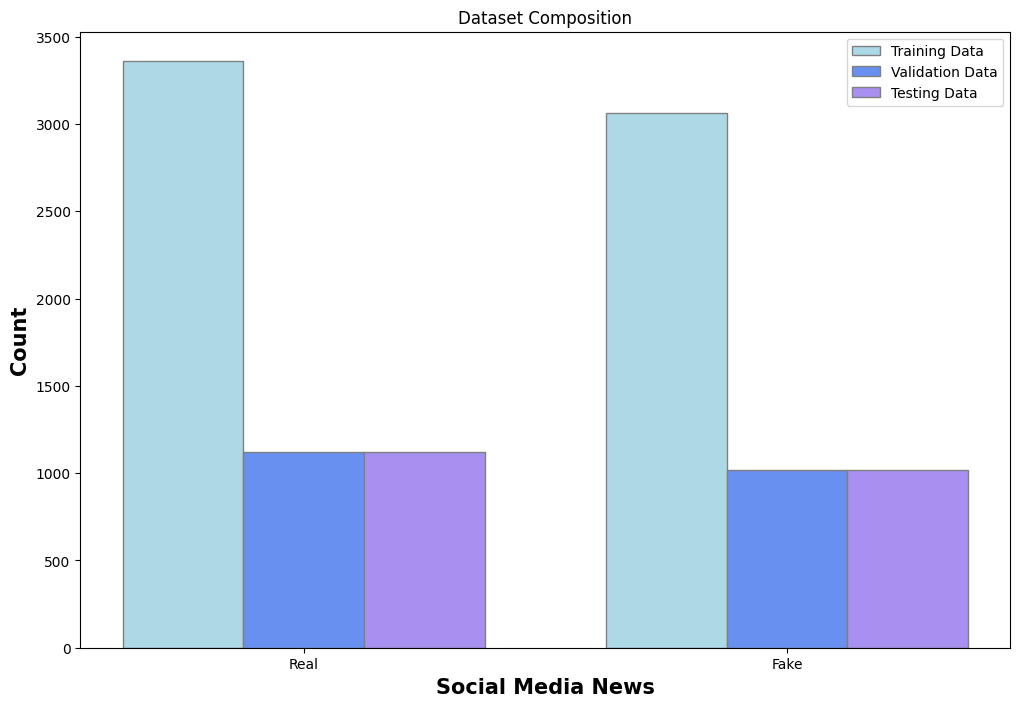

time: 241 ms (started: 2023-12-07 06:53:09 +00:00)


In [11]:
a= train['label'].value_counts()
a_species = a.index
a_count = a.values

b= val['label'].value_counts()
b_species = b.index
b_count = b.values

c= test['label'].value_counts()
c_species = c.index
c_count = c.values

#plt.bar(a_species, a_count, color = 'lightgreen', label='Training Data')
#plt.bar(b_species, b_count, color = 'red', label='Validation Data')
#plt.bar(c_species, c_count, color = 'purple', label='Testing Data')
#plt.xlabel('News Category')
#plt.ylabel('Count')
#plt.show()

# set width of bar
barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

# set height of bar
#IT = [12, 30, 1, 8, 22]
#ECE = [28, 6, 16, 5, 10]
#CSE = [29, 3, 24, 25, 17]

# Set position of bar on X axis
br1 = np.arange(len(a_count))
br2 = [x + barWidth for x in br1]
br3 = [x + barWidth for x in br2]

# Make the plot
plt.bar(br1, a_count, color ='lightblue', width = barWidth,
        edgecolor ='grey', label='Training Data')
plt.bar(br2, b_count, color ='#6890F0', width = barWidth,
        edgecolor ='grey', label='Validation Data')
plt.bar(br3, c_count, color ='#A890F0', width = barWidth,
        edgecolor ='grey', label='Testing Data')

# Adding Xticks
plt.xlabel('Social Media News', fontweight ='bold', fontsize = 15)
plt.ylabel('Count', fontweight ='bold', fontsize = 15)
plt.xticks([r + barWidth for r in range(len(a_count))],
        ['Real', 'Fake'])
plt.title('Dataset Composition')

plt.legend()
plt.show()

(array([3060.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
        3360.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

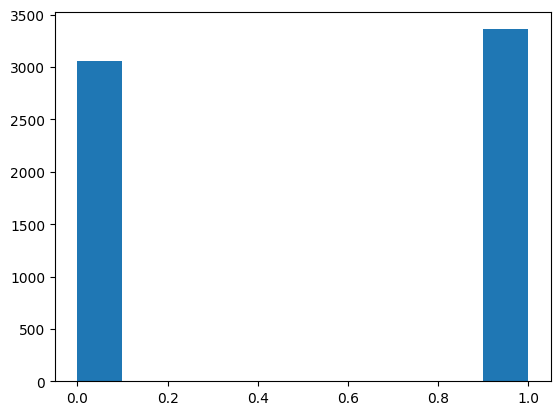

time: 205 ms (started: 2023-12-07 06:53:13 +00:00)


In [12]:
plt.hist(labels)

##**Define Metrices**

In [14]:
def print_metrices(pred,true):
    accuracy = accuracy_score(pred,true)
    precision = precision_score(pred, true, average = 'weighted')
    recall = recall_score(pred,true, average = 'weighted')
    f1 = f1_score(pred, true, average = 'weighted')
    print("Accuracy : ",accuracy)
    print("Precison : ",precision)
    print("Recall : ",recall)
    print("F1 : ",f1)
    return accuracy, precision, recall, f1

time: 808 µs (started: 2023-12-07 06:53:21 +00:00)


# Original Baseline for Training, Validation, and Testing

## Method for Training and Validation

In [15]:
# This method is adapted from the original source-code on:
# https://github.com/parthpatwa/covid19-fake-news-detection/blob/main/ml_baseline.ipynb
def train_val_baseline(pipeline, method_title):
  print(f'Training and Validation of {method_title}')

  # get the starting time
  t0 = time()
  fit = pipeline.fit(train['tweet'],train['label'])
  pred=pipeline.predict(val['tweet'])
  print(f'Time: {time() - t0} \nPerformance score:')

  # display the elapsed time and performance scores
  print_metrices(pred, val['label'])
  plot_confusion_matrix(confusion_matrix(val['label'], pred),
                        target_names=['fake','real'],
                        normalize = False,
                        title = f'Confusion matix of {method_title} on val data')

  val_ori = pd.read_csv(PATH + 'Constraint_Val.csv')
  val_misclass_df = val_ori[pred!=val['label']]
  val_misclass_df.info()
  val_misclass_df.to_csv(PATH + f'{method_title}_val_misclassified.csv', index=False)


time: 679 µs (started: 2023-12-07 06:53:24 +00:00)


## Method for Testing

In [16]:
# This method is adapted from the original source-code on:
# https://github.com/parthpatwa/covid19-fake-news-detection/blob/main/ml_baseline-test.ipynb
def test_baseline(pipeline, method_title):
  print(f'Testing Baseline of {method_title}')

  # get the starting time
  t0 = time()
  fit = pipeline.fit(train['tweet'],train['label'])
  pred=pipeline.predict(test['tweet'])

  # display the elapsed time and performance scores
  print(f'Time: {time() - t0} \nPerformance score:')

  print_metrices(pred, test['label'])
  plot_confusion_matrix(confusion_matrix(val['label'], pred),
                        target_names=['fake','real'],
                        normalize = False,
                        title = f'Confusion matix of {method_title} on Test data')

  test_ori = pd.read_csv(PATH + 'Constraint_Test.csv')
  test_misclass_df = test_ori[pred!=test['label']]
  test_misclass_df.info()
  test_misclass_df.to_csv(PATH + f'{method_title}_test_misclassified.csv', index=False)


time: 778 µs (started: 2023-12-07 06:53:37 +00:00)


## Support Vector Machine

Training and Validation of SVM
Time: 0.22225594520568848 
Performance score:
Accuracy :  0.9345794392523364
Precison :  0.9348008619335585
Recall :  0.9345794392523364
F1 :  0.9345519215989282


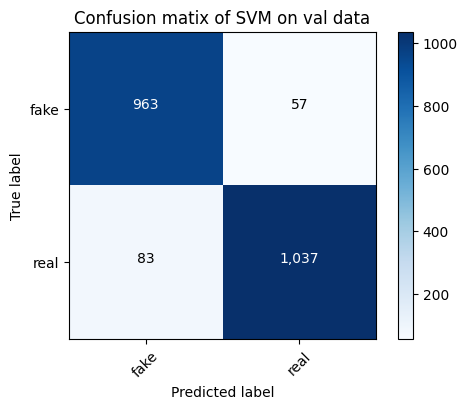

<class 'pandas.core.frame.DataFrame'>
Int64Index: 140 entries, 1 to 2138
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      140 non-null    int64 
 1   tweet   140 non-null    object
 2   label   140 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.4+ KB



Testing Baseline of SVM
Time: 0.2257845401763916 
Performance score:
Accuracy :  0.9331775700934579
Precison :  0.9332800024215294
Recall :  0.9331775700934579
F1 :  0.9331550818269843


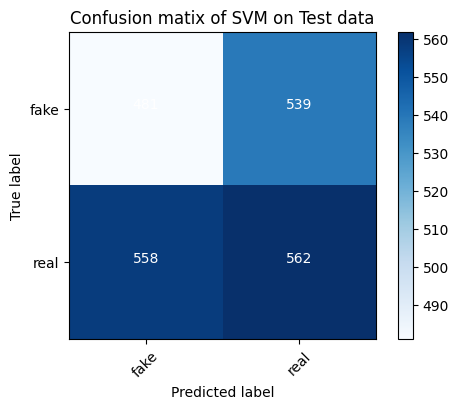

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143 entries, 5 to 2111
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      143 non-null    int64 
 1   tweet   143 non-null    object
dtypes: int64(1), object(1)
memory usage: 3.4+ KB
time: 1.14 s (started: 2023-12-07 00:52:23 +00:00)


In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', LinearSVC())
    ])

train_val_baseline(pipeline, 'SVM')
print('\n\n')
test_baseline(pipeline, 'SVM')

## Logistic Regression

Training and Validation of LR
Time: 0.7090613842010498 
Performance score:
Accuracy :  0.927570093457944
Precison :  0.9279421090866252
Recall :  0.927570093457944
F1 :  0.9275350904769529


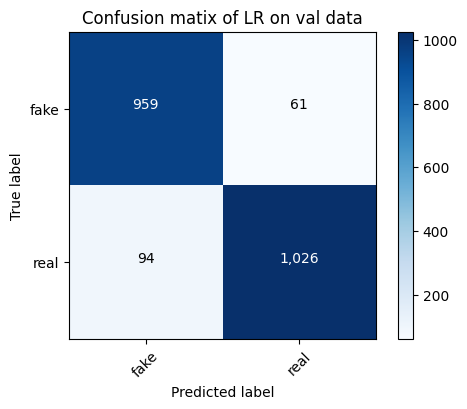

<class 'pandas.core.frame.DataFrame'>
Int64Index: 155 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      155 non-null    int64 
 1   tweet   155 non-null    object
 2   label   155 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB



Testing Baseline of LR
Time: 0.6993527412414551 
Performance score:
Accuracy :  0.9196261682242991
Precison :  0.9201244960601063
Recall :  0.9196261682242991
F1 :  0.919584784735393


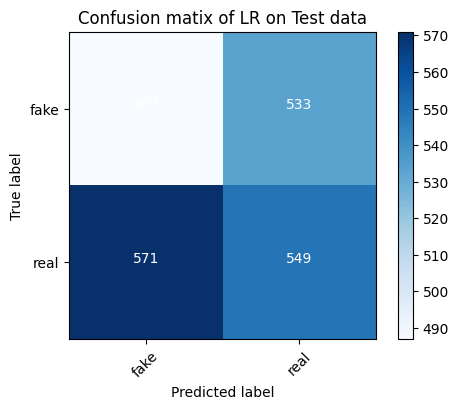

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 5 to 2132
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      172 non-null    int64 
 1   tweet   172 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.0+ KB
time: 2.09 s (started: 2023-12-07 00:52:36 +00:00)


In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', LogisticRegression())
    ])

train_val_baseline(pipeline, 'LR')
print('\n\n')
test_baseline(pipeline, 'LR')

## Gradient Boosting

Training and Validation of GDBT
Time: 4.153422594070435 
Performance score:
Accuracy :  0.8682242990654205
Precison :  0.8708280648708081
Recall :  0.8682242990654205
F1 :  0.8681856239752643


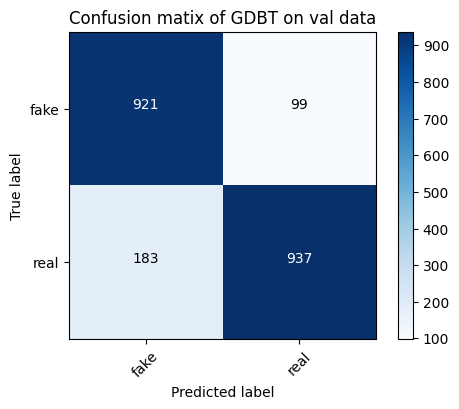

<class 'pandas.core.frame.DataFrame'>
Int64Index: 282 entries, 1 to 2130
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      282 non-null    int64 
 1   tweet   282 non-null    object
 2   label   282 non-null    object
dtypes: int64(1), object(2)
memory usage: 8.8+ KB



Testing Baseline of GDBT
Time: 4.1674582958221436 
Performance score:
Accuracy :  0.8691588785046729
Precison :  0.8720442943532553
Recall :  0.8691588785046729
F1 :  0.8691287071864423


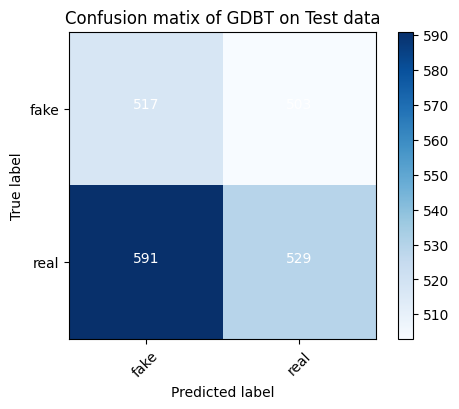

<class 'pandas.core.frame.DataFrame'>
Int64Index: 280 entries, 4 to 2139
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      280 non-null    int64 
 1   tweet   280 non-null    object
dtypes: int64(1), object(1)
memory usage: 6.6+ KB
time: 9.21 s (started: 2023-12-07 00:02:54 +00:00)


In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', GradientBoostingClassifier())
    ])

train_val_baseline(pipeline, 'GDBT')
print('\n\n')
test_baseline(pipeline, 'GDBT')

## Decision Tree

Training and Validation of DT
Time: 1.038419485092163 
Performance score:
Accuracy :  0.8542056074766355
Precison :  0.8545578254666353
Recall :  0.8542056074766355
F1 :  0.8542913328863943


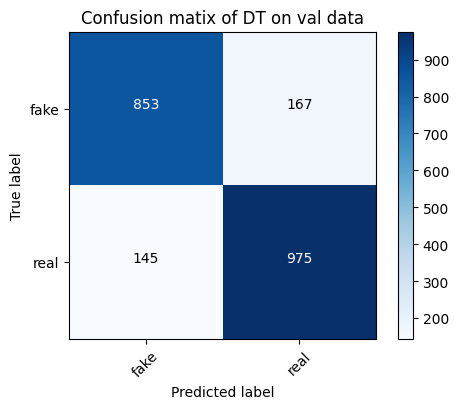

<class 'pandas.core.frame.DataFrame'>
Int64Index: 312 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      312 non-null    int64 
 1   tweet   312 non-null    object
 2   label   312 non-null    object
dtypes: int64(1), object(2)
memory usage: 9.8+ KB



Testing Baseline of DT
Time: 1.0057437419891357 
Performance score:
Accuracy :  0.8588785046728972
Precison :  0.8595944592790387
Recall :  0.8588785046728972
F1 :  0.8590194515623762


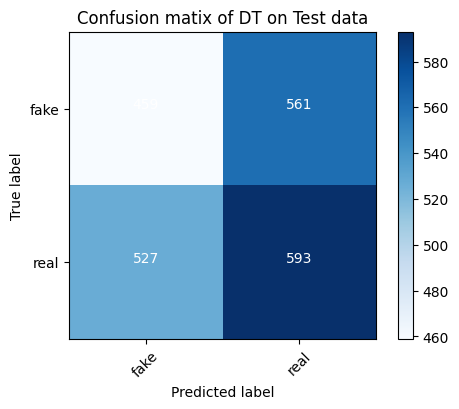

<class 'pandas.core.frame.DataFrame'>
Int64Index: 302 entries, 4 to 2132
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      302 non-null    int64 
 1   tweet   302 non-null    object
dtypes: int64(1), object(1)
memory usage: 7.1+ KB
time: 3.73 s (started: 2023-12-07 06:53:47 +00:00)


In [17]:
#minor variations in final results due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', tree.DecisionTreeClassifier())
    ])

train_val_baseline(pipeline, 'DT')
print('\n\n')
test_baseline(pipeline, 'DT')

## Multinomial Naive Bayes

Training and Validation of MNB
Time: 0.2696361541748047 
Performance score:
Accuracy :  0.9196261682242991
Precison :  0.9197314065813241
Recall :  0.9196261682242991
F1 :  0.9196498207544862


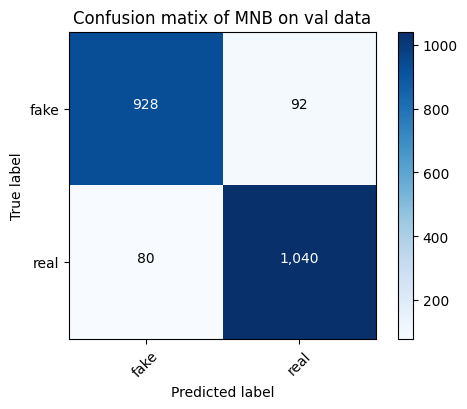

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      172 non-null    int64 
 1   tweet   172 non-null    object
 2   label   172 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.4+ KB



Testing Baseline of MNB
Time: 0.17998862266540527 
Performance score:
Accuracy :  0.9163551401869159
Precison :  0.9167202102803739
Recall :  0.9163551401869159
F1 :  0.9164124126712998


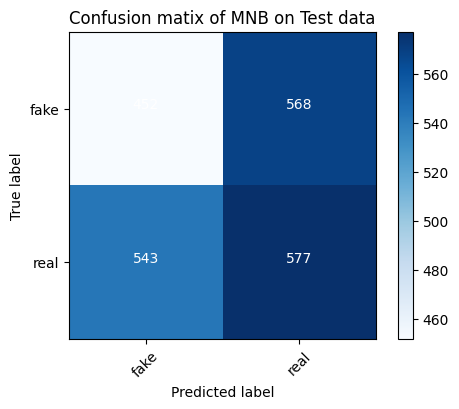

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 5 to 2121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      179 non-null    int64 
 1   tweet   179 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.2+ KB
time: 3.64 s (started: 2023-12-07 06:53:57 +00:00)


In [18]:
#minor variations in final results due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', MultinomialNB(alpha=0.1))
    ])

train_val_baseline(pipeline, 'MNB')
print('\n\n')
test_baseline(pipeline, 'MNB')

## Complement Naive Bayes

Training and Validation of MNC
Time: 0.18024086952209473 
Performance score:
Accuracy :  0.9191588785046729
Precison :  0.9191734322233567
Recall :  0.9191588785046729
F1 :  0.9191643457744798


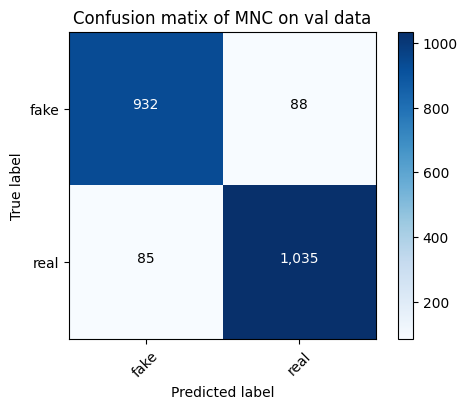

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      173 non-null    int64 
 1   tweet   173 non-null    object
 2   label   173 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.4+ KB



Testing Baseline of MNC
Time: 0.18267035484313965 
Performance score:
Accuracy :  0.9191588785046729
Precison :  0.9192788423780727
Recall :  0.9191588785046729
F1 :  0.9191848824464603


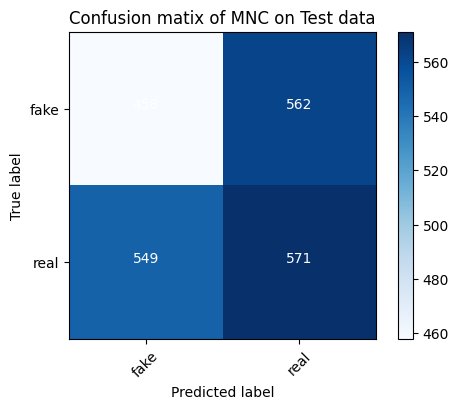

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 5 to 2121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      173 non-null    int64 
 1   tweet   173 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.1+ KB
time: 888 ms (started: 2023-12-07 06:56:38 +00:00)


In [20]:
#minor variations in final results due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', ComplementNB(alpha=0.1))
    ])

train_val_baseline(pipeline, 'MNC')
print('\n\n')
test_baseline(pipeline, 'MNC')

#Choosing the Right Hyperparameter for Training

## Use Hyperparameter Searching Method

In [ ]:
def hyper_param_search(pipeline, parameter, file_name, cv_range = range(5,11)):
  performance_array = []
  # Perform the grid search
  for i in cv_range:
      grid_search = GridSearchCV(pipeline, parameters, cv=i, n_jobs=2, verbose=1)
      t0 = time()
      grid_search.fit(train['tweet'], train['label'])
      gs_time = time() - t0

      # Display the best parameters, its testing score, and validation score
      gs_best_param = grid_search.best_params_
      gs_best_score = grid_search.best_score_
      gs_val_score = grid_search.score(val['tweet'], val['label'])

      # Print the best parameters and score for each cross-validation value
      print("Cross-validation value: ", i)
      print("Best parameters: ", gs_best_param)
      print("Best Train score: ", gs_best_score)
      print('Validation Score:', gs_val_score)
      print('Runtime:', gs_time)

      # Populate the parameters, scores, and running time for later table
      performance_array.append([i, gs_best_param,
                                gs_best_score,
                                gs_val_score,
                                gs_time])

  # convert the previously collected performance array into Panda DataFrame
  # and arrange the columns
  data_df = pd.DataFrame(performance_array, columns=['k', 'best_param',
                                                     'best_score', 'val_score',
                                                     'time'])

  # Write the DataFrame to a CSV file
  data_df.to_csv(PATH + file_name, index=False)

time: 1.76 ms (started: 2023-12-07 01:06:58 +00:00)


##Multinomial Naive Bayes

###Without SMOTE

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB())
])

# Define the parameters to be tuned
parameters = {
    #'mnb__norm': [True, False],
    'mnb__alpha': [100, 10, 1.0, 0.1, 0.01]#,
    #'sampling__k_neighbors': np.arange(1, 51).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'MNB_HYPERPARAM.csv')


Fitting 5 folds for each of 5 candidates, totalling 25 fits
Cross-validation value:  5
Best parameters:  {'mnb__alpha': 0.1}
Best Train score:  0.9185358255451714
Validation Score: 0.9196261682242991
Runtime: 3.436049699783325
Fitting 6 folds for each of 5 candidates, totalling 30 fits
Cross-validation value:  6
Best parameters:  {'mnb__alpha': 0.1}
Best Train score:  0.920404984423676
Validation Score: 0.9196261682242991
Runtime: 2.5468719005584717
Fitting 7 folds for each of 5 candidates, totalling 35 fits
Cross-validation value:  7
Best parameters:  {'mnb__alpha': 0.1}
Best Train score:  0.9196285808640673
Validation Score: 0.9196261682242991
Runtime: 3.003772735595703
Fitting 8 folds for each of 5 candidates, totalling 40 fits
Cross-validation value:  8
Best parameters:  {'mnb__alpha': 0.1}
Best Train score:  0.9185384142383766
Validation Score: 0.9196261682242991
Runtime: 3.3820409774780273
Fitting 9 folds for each of 5 candidates, totalling 45 fits
Cross-validation value:  9
Best

####Training, Validation, and Testing

Training and Validation of MNB+Hyperparameter_Tuned
Time: 0.18334412574768066 
Performance score:
Accuracy :  0.9196261682242991
Precison :  0.9197314065813241
Recall :  0.9196261682242991
F1 :  0.9196498207544862


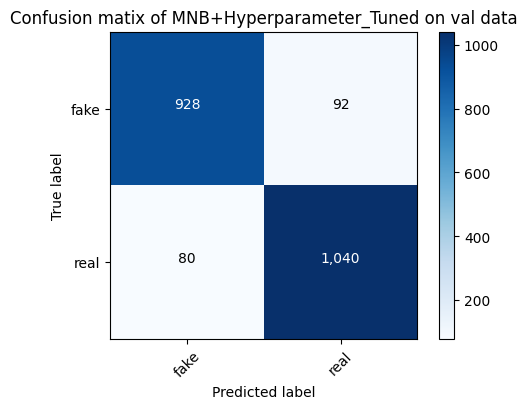

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      172 non-null    int64 
 1   tweet   172 non-null    object
 2   label   172 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.4+ KB



Testing Baseline of MNB+Hyperparameter_Tuned
Time: 0.17798566818237305 
Performance score:
Accuracy :  0.9163551401869159
Precison :  0.9167202102803739
Recall :  0.9163551401869159
F1 :  0.9164124126712998


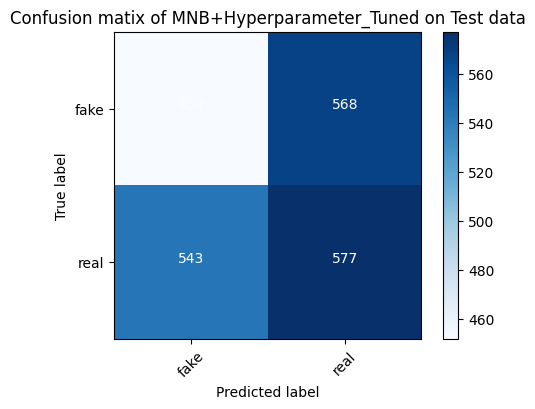

<class 'pandas.core.frame.DataFrame'>
Int64Index: 179 entries, 5 to 2121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      179 non-null    int64 
 1   tweet   179 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.2+ KB
time: 914 ms (started: 2023-12-07 06:57:43 +00:00)


In [21]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('mnb', MultinomialNB(alpha=0.1))
])

train_val_baseline(pipeline, 'MNB+Hyperparameter_Tuned')
print('\n\n')
test_baseline(pipeline, 'MNB+Hyperparameter_Tuned')

###With SMOTE

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE)),
    ('mnb', MultinomialNB(alpha=0.1))
])

# Define the parameters to be tuned
parameters = {
    #'mnb__alpha': [100, 10, 1.0, 0.1, 0.01],
    #'sampling__sampling_strategy': ['minority', 'not minority', 'all'],
    'sampling__k_neighbors': np.arange(1, 101).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'MNB_SMOTE_HYPERPARAM.csv')


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Cross-validation value:  5
Best parameters:  {'sampling__k_neighbors': 31}
Best Train score:  0.9208722741433022
Validation Score: 0.9210280373831776
Runtime: 1007.7943971157074
Fitting 6 folds for each of 100 candidates, totalling 600 fits
Cross-validation value:  6
Best parameters:  {'sampling__k_neighbors': 54}
Best Train score:  0.9225856697819314
Validation Score: 0.9182242990654206
Runtime: 1293.61337351799
Fitting 7 folds for each of 100 candidates, totalling 700 fits
Cross-validation value:  7
Best parameters:  {'sampling__k_neighbors': 59}
Best Train score:  0.9219650540453671
Validation Score: 0.9196261682242991
Runtime: 1555.536230802536
Fitting 8 folds for each of 100 candidates, totalling 800 fits
Cross-validation value:  8
Best parameters:  {'sampling__k_neighbors': 15}
Best Train score:  0.9199403809902392
Validation Score: 0.9191588785046729
Runtime: 1825.634346961975
Fitting 9 folds for each of 100 candidat

####Training, Validation, and Testing

Training and Validation of MNB_SMOTE_Hyperparameter_Tuned
Time: 5.243697881698608 
Performance score:
Accuracy :  0.9200934579439253
Precison :  0.9201603854158487
Recall :  0.9200934579439253
F1 :  0.9201106193143505


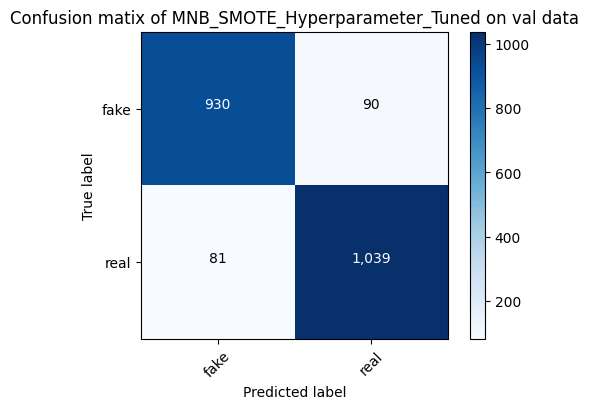

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      171 non-null    int64 
 1   tweet   171 non-null    object
 2   label   171 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.3+ KB



Testing Baseline of MNB_SMOTE_Hyperparameter_Tuned
Time: 3.7771029472351074 
Performance score:
Accuracy :  0.9186915887850468
Precison :  0.9188605722662897
Recall :  0.9186915887850468
F1 :  0.9187246382051296


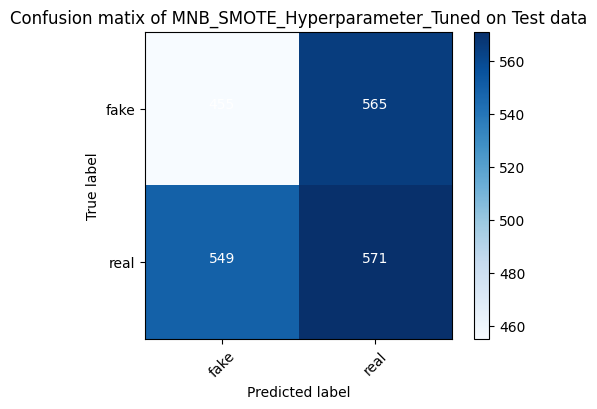

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 5 to 2121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      174 non-null    int64 
 1   tweet   174 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.1+ KB
time: 10.1 s (started: 2023-12-07 06:42:30 +00:00)


In [32]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE,
                       k_neighbors=79)),
                       #sampling_strategy='minority')),
    ('mnb', MultinomialNB(alpha=0.1))
])

train_val_baseline(pipeline, 'MNB_SMOTE_Hyperparameter_Tuned')
print('\n\n')
test_baseline(pipeline, 'MNB_SMOTE_Hyperparameter_Tuned')

##Complement Naive Bayes

###Without SMOTE

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('mnc', ComplementNB())
])

# Define the parameters to be tuned
parameters = {
    'mnc__norm': [True, False],
    'mnc__alpha': [100, 10, 1.0, 0.1, 0.01]#,
    #'sampling__k_neighbors': np.arange(1, 51).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'MNC_HYPERPARAM.csv')


####Training, Validation, and Testing

Training and Validation of MNC Hyperparameter Tuned
Time: 0.2470228672027588 
Performance score:
Accuracy :  0.9191588785046729
Precison :  0.9191734322233567
Recall :  0.9191588785046729
F1 :  0.9191643457744798


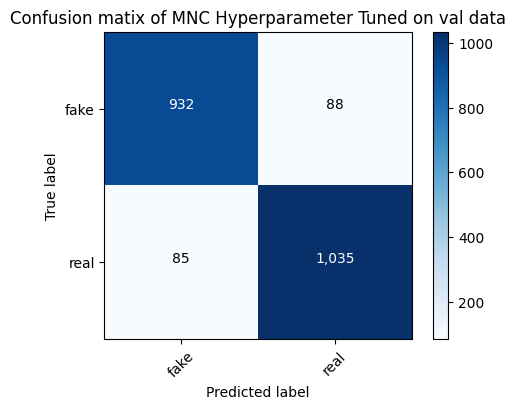

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      173 non-null    int64 
 1   tweet   173 non-null    object
 2   label   173 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.4+ KB



Testing Baseline of MNC Hyperparameter Tuned
Time: 0.23211193084716797 
Performance score:
Accuracy :  0.9191588785046729
Precison :  0.9192788423780727
Recall :  0.9191588785046729
F1 :  0.9191848824464603


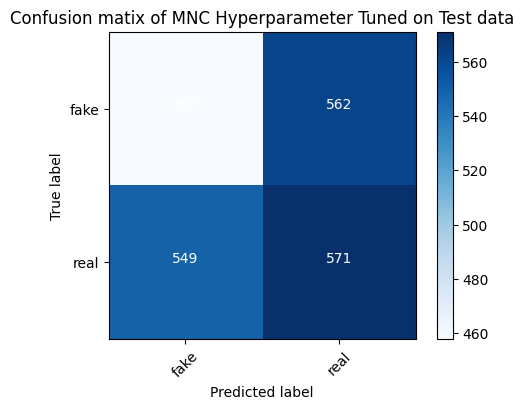

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173 entries, 5 to 2121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      173 non-null    int64 
 1   tweet   173 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.1+ KB
time: 1.22 s (started: 2023-12-07 00:58:42 +00:00)


In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('mnc', ComplementNB(alpha=0.1))
])

train_val_baseline(pipeline, 'MNC Hyperparameter Tuned')
print('\n\n')
test_baseline(pipeline, 'MNC Hyperparameter Tuned')

###With SMOTE

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE)),
    ('mnc', ComplementNB(alpha=0.1))
])

# Define the parameters to be tuned
parameters = {
    #'mnc__norm': [True, False],
    #'mnc__alpha': [100, 10, 1.0, 0.1, 0.01],
    #'sampling__sampling_strategy': ['minority', 'not minority', 'all'],
    'sampling__k_neighbors': np.arange(1, 101).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'MNC_SMOTE_HYPERPARAM.csv')


Fitting 5 folds for each of 100 candidates, totalling 500 fits


####Training, Validation, and Testing

Training and Validation of MNC and SMOTE (k=45) Hyperparameter Tuned
Time: 4.337961673736572 
Performance score:
Accuracy :  0.9210280373831776
Precison :  0.9210736783030969
Recall :  0.9210280373831776
F1 :  0.921040985729237


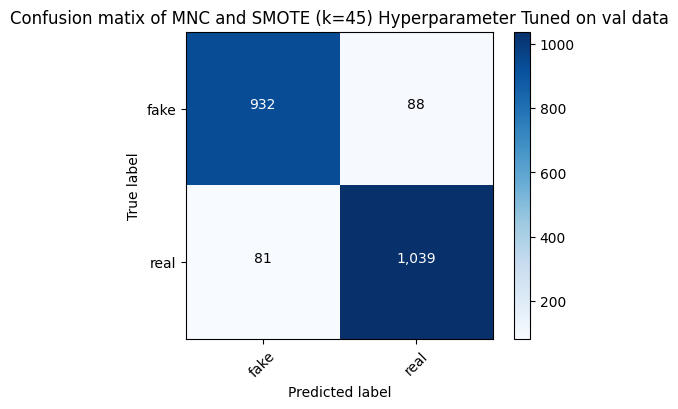

<class 'pandas.core.frame.DataFrame'>
Int64Index: 169 entries, 1 to 2135
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      169 non-null    int64 
 1   tweet   169 non-null    object
 2   label   169 non-null    object
dtypes: int64(1), object(2)
memory usage: 5.3+ KB



Testing Baseline of MNC and SMOTE (k=45) Hyperparameter Tuned
Time: 5.265940189361572 
Performance score:
Accuracy :  0.9200934579439253
Precison :  0.9202794003115264
Recall :  0.9200934579439253
F1 :  0.9201282667941524


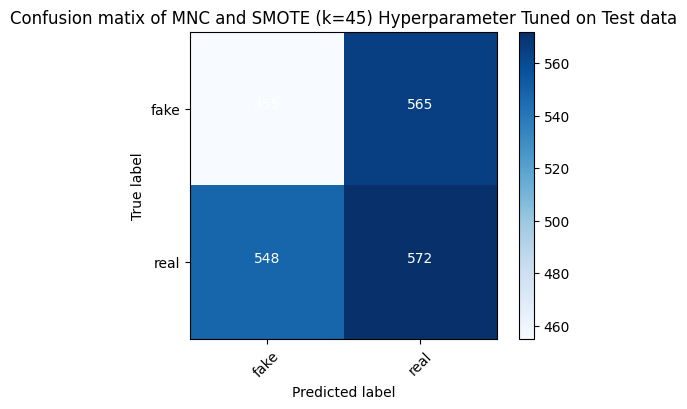

<class 'pandas.core.frame.DataFrame'>
Int64Index: 171 entries, 5 to 2121
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      171 non-null    int64 
 1   tweet   171 non-null    object
dtypes: int64(1), object(1)
memory usage: 4.0+ KB
time: 10.6 s (started: 2023-12-07 01:02:12 +00:00)


In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE, k_neighbors=74)),#,
                       #sampling_strategy='minority')),
    ('mnc', ComplementNB(alpha=0.1))
])

train_val_baseline(pipeline, 'MNC and SMOTE (k=45) Hyperparameter Tuned')
print('\n\n')
test_baseline(pipeline, 'MNC and SMOTE (k=45) Hyperparameter Tuned')

##SVM Hyperparameter Tuning

###Without SMOTE

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svm', LinearSVC(random_state=RANDOM_STATE, max_iter=20000))
])

# Define the parameters to be tuned
parameters = {
    'svm__C': [0.1, 1, 10],
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'SVM_HYPERPARAM.csv')

####Training, Validation, and Testing

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('svm', LinearSVC(random_state=RANDOM_STATE, max_iter=20000, C=1))
])

train_val_baseline(pipeline, 'SVM with Hyperparameter Tuned')
print('\n\n')
test_baseline(pipeline, 'SVM with Hyperparameter Tuned')

###With SMOTE

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE)),
    ('svm', LinearSVC(random_state=RANDOM_STATE, max_iter=20000, C=1))
])

# Define the parameters to be tuned
parameters = {
    #'svm__C': [0.1, 1, 10],
    'sampling__sampling_strategy': ['minority', 'not minority', 'all'],
    'sampling__k_neighbors': np.arange(1, 51).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'SVM_SMOTE_HYPERPARAM.csv')

####Training, Validation, and Testing

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE, k_neighbors=36,
                       sampling_strategy='minority')),
    ('svm', LinearSVC(random_state=RANDOM_STATE, max_iter=20000, C=1))
])

train_val_baseline(pipeline, 'SVM and SMOTE with Hyperparameter Tuned')
print('\n\n')
test_baseline(pipeline, 'SVM and SMOTE with Hyperparameter Tuned')

##Logistic Regression

###Without SMOTE

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000))
])

# Define the parameters to be tuned
parameters = {
    'lr__C': [100, 10, 1.0, 0.1, 0.01]#,
    #'sampling__k_neighbors': np.arange(1, 51).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'LR_HYPERPARAM.csv')

####Training, Validation, and Testing

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, C=100))
])

train_val_baseline(pipeline, 'LR with Hyperparameter Tuned')
print('\n\n')
test_baseline(pipeline, 'LR with Hyperparameter Tuned')

###With SMOTE

In [ ]:
# Define the pipeline
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE)),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, C=100))
])

# Define the parameters to be tuned
parameters = {
    #'lr__C': [100, 10, 1.0, 0.1, 0.01],
    'sampling__sampling_strategy': ['minority', 'not minority', 'all'],
    'sampling__k_neighbors': np.arange(1, 51).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'LR_SMOTE_HYPERPARAM.csv')

####Training, Validation, and Testing

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE, k_neighbors=30,
                       sampling_strategy='minority')),
    ('lr', LogisticRegression(random_state=RANDOM_STATE, max_iter=1000, C=100))
])

train_val_baseline(pipeline, 'LR and SMOTE (k=30) with Hyperparameter Tuned')
print('\n\n')
test_baseline(pipeline, 'LR and SMOTE (k=30) with Hyperparameter Tuned')

##GradientBoosting

###Without SMOTE

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE))
])

# Define the parameters to be tuned
parameters = {
    'gb__n_estimators': [750, 1000, 1500],
    'gb__learning_rate': [1.0, 0.1, 0.01],
    'gb__subsample': np.arange(0.5, 1.1, 0.1).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'GB_HYPERPARAM.csv')


####Training, Validation, and Testing

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE,
                                      learning_rate=0.1, n_estimators=1500,
                                      subsample=0.7999999999999999))
])

train_val_baseline(pipeline, 'GB with Hyperparameter Tuned')
print('\n\n')
test_baseline(pipeline, 'GB with Hyperparameter Tuned')

###With SMOTE

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE, sampling_strategy='minority')),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE,
                                      learning_rate=0.1,
                                      n_estimators=1500,
                                      subsample=0.8999999999999999))
])

# Define the parameters to be tuned
parameters = {
    #'gb__n_estimators': [50, 100, 200],
    #'gb__learning_rate': [100, 10, 1.0, 0.1, 0.01],
    #'sampling__sampling_strategy': ['minority', 'not minority', 'all'],
    'sampling__k_neighbors': np.arange(1, 51).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'GB_SMOTE_HYPERPARAM.csv')


####Training, Validation, and Testing

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE,
                       sampling_strategy='minority',
                       k_neighbors=2)),
    ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE,
                                      learning_rate=0.1, n_estimators=1500,
                                      subsample=0.7999999999999999))
])

train_val_baseline(pipeline, 'GB and SMOTE (k=2) with Hyperparameter Tuned')
print('\n\n')
test_baseline(pipeline, 'GB and SMOTE (k=2) with Hyperparameter Tuned')

##Decision Tree

###Without SMOTE

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    #('sampling', SMOTE(random_state=RANDOM_STATE)),
    ('dt', tree.DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Define the parameters to be tuned
parameters = {
    #'dt__max_depth': np.arange(3, 52, 2).tolist(), #[3, 5, 7],
    'dt__min_samples_split': np.arange(2, 21, 2).tolist(),# [2, 4, 6],
    'dt__class_weight': [None, 'balanced']
    #'sampling__k_neighbors': np.arange(1, 51).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'DT_HYPERPARAM.csv')

####Training, Validation, and Testing

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('dt', tree.DecisionTreeClassifier(random_state=RANDOM_STATE,
                                       class_weight=None,
                                       min_samples_split=16))
])

train_val_baseline(pipeline, 'DT with Hyperparameter Tuned')
print('\n\n')
test_baseline(pipeline, 'DT with Hyperparameter Tuned')

###With SMOTE

In [ ]:
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE)),
    ('dt', tree.DecisionTreeClassifier(random_state=RANDOM_STATE,
                                       min_samples_split=16,
                                       class_weight=None))
])

# Define the parameters to be tuned
parameters = {
    #'dt__max_depth': np.arange(3, 12, 2).tolist(), #[3, 5, 7],
    #'dt__min_samples_split': np.arange(2, 11, 2).tolist(), #[2, 4, 6],
    'sampling__sampling_strategy': ['minority', 'not minority', 'all'],
    'sampling__k_neighbors': np.arange(1, 51).tolist()
}

# Perform hyperparameter search
hyper_param_search(pipeline, parameters, 'DT_SMOTE_HYPERPARAM.csv')

####Training, Validation, and Testing

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('sampling', SMOTE(random_state=RANDOM_STATE,
                       k_neighbors=29,
                       sampling_strategy='minority')),
    ('dt', tree.DecisionTreeClassifier(random_state=RANDOM_STATE,
                                       class_weight=None,
                                       min_samples_split=16))
])

train_val_baseline(pipeline, 'DT and SMOTE (k=29) with Hyperparameter Tuned')
print('\n\n')
test_baseline(pipeline, 'DT and SMOTE (k=29) with Hyperparameter Tuned')

# Using Test Dataset

## The Testing Subroutine

In [ ]:
# Define the test_method subroutine
def test_method(pipeline, method_title):
  t0 = time()
  # fit the pipeline with the training data
  fit = pipeline.fit(train['tweet'],train['label'])

  # predict the test data
  pred=pipeline.predict(test['tweet'])

  # display the elapsed runtime
  print(f"Done in {time() - t0:.3f}s")

  # describe the metrices
  print_metrices(pred,test['label'])

  # display the confusion matrix
  plot_confusion_matrix(confusion_matrix(test['label'], pred), \
                        target_names=['fake','real'], normalize = False, \
                        title = f'Confusion matrix of {method_title} on test data')

  # locate the constrain test file
  test_ori = pd.read_csv(PATH + 'Constraint_Test.csv')

  # display the misclassified data
  test_misclass_df = test_ori[pred!=test['label']]
  test_misclass_df.info()

  # save the result into a file
  test_misclass_df.to_csv(PATH + f'{method_title}_test_misclassified.csv')

## Multinomial Naive Bayes

### Without SMOTE

In [ ]:
# Define the pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('mnb', MultinomialNB(alpha=0.1))
    ])

# call the test method
test_method(pipeline, 'MNB')

### With SMOTE

In [ ]:
# Define the pipeline
pipeline = Pipeline([
        #('smt', smt),
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('sampling', SMOTE(random_state=RANDOM_STATE,
                           k_neighbors=9,
                           sampling_strategy='minority')),
        ('mnb', MultinomialNB(alpha=0.1))
    ])

# call the test method
test_method(pipeline, 'MNB+SMOTE with k=9')


## Complement Naive Bayes

### Without SMOTE

In [ ]:
pipeline = Pipeline([
        #('smt', smt),
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('mnc', ComplementNB(alpha=0.1, norm=False))
    ])

# call the test method
test_method(pipeline, 'MNC')

### With SMOTE

In [ ]:
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('sampling', SMOTE(random_state=RANDOM_STATE,
                           k_neighbors=9,
                           sampling_strategy='minority')),
        ('mnc', ComplementNB(alpha=0.1, norm=False))
    ])

# call the test method
test_method(pipeline, 'MNC+SMOTE with k=9')


## Support Vector Machine

### Without SMOTE

In [ ]:
# define the pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        #('smote', SMOTE(random_state=21,k_neighbors=9)),
        ('c', LinearSVC(random_state=RANDOM_STATE, max_iter=20000, C=1))
    ])

# call the test method
test_method(pipeline, 'SVM')


### With SMOTE

In [ ]:
# define the pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('sampling', SMOTE(random_state = RANDOM_STATE,
                           k_neighbors = 20,
                           sampling_strategy = 'minority')),
        ('c', LinearSVC(random_state=RANDOM_STATE, max_iter=20000, C=1))
    ])

# call the test method
test_method(pipeline, 'SVM+SMOTE with k=20')


## Logistic Regression

### Without SMOTE

In [ ]:
# Define the pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', LogisticRegression(random_state=RANDOM_STATE, C=100))
    ])

# call the test method
test_method(pipeline, 'LR')

### With SMOTE

In [ ]:
# Define the pipeline
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('sampling', SMOTE(random_state=RANDOM_STATE,
                           k_neighbors=30,
                           sampling_strategy='minority')),
        ('c', LogisticRegression(random_state=RANDOM_STATE, C=100))
    ])

# call the test method
test_method(pipeline, 'LR+SMOTE with k=30')

## Gradient Boosting

### Without SMOTE

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
      ('bow', CountVectorizer()),
      ('tfidf', TfidfTransformer()),
      ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE,
                                        learning_rate=0.1,
                                        n_estimators=1500,
                                        subsample=0.8999999999999999))
    ])

# call the test method
test_method(pipeline, 'GDBT')

### With SMOTE

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('sampling', SMOTE(random_state=RANDOM_STATE,
                           k_neighbors=29,
                           sampling_strategy= 'minority')),
        ('gb', GradientBoostingClassifier(random_state=RANDOM_STATE,
                                          learning_rate=0.1,
                                          n_estimators=1500,
                                          subsample=0.8999999999999999))
    ])
# {'sampling__k_neighbors': 29, 'sampling__sampling_strategy': 'minority'}
# call the test method
test_method(pipeline, 'GDBT+SMOTE with k=29')



## Decision Tree

### Without SMOTE

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('c', tree.DecisionTreeClassifier(random_state=RANDOM_STATE,
                                          min_samples_split=16))
    ])

# call the test method
test_method(pipeline, 'DT')


### With SMOTE

In [ ]:
#minor variations in final results due to randomness
pipeline = Pipeline([
        ('bow', CountVectorizer()),
        ('tfidf', TfidfTransformer()),
        ('sampling', SMOTE(random_state=RANDOM_STATE, k_neighbors=2)),
        ('c', tree.DecisionTreeClassifier(random_state=RANDOM_STATE,
                                          min_samples_split=16))
    ])

# call the test method
test_method(pipeline, 'DT+SMOTE with k=2')
